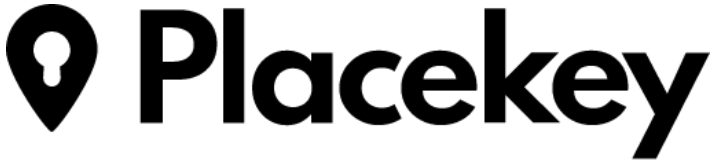

# Joining POI and non-POI datasets with Placekey

This tutorial will teach you how to join POI and non-POI datasets with Placekey using Python in a Google Colab environment.

Our POI dataset is a subset of SafeGraph Places, which contains info on all POIs in San Francisco. Our non-POI dataset contains the latitude/longitude coordinates for all parking meters in San Francisco.

**The goal of this tutorial is to get you familiar with the process of joining POI data with non-POI data on Placekey, including the limitations and considerations to be aware of.**


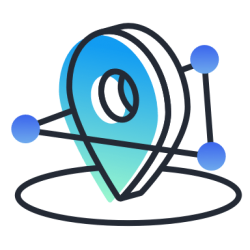

# Getting Started
Before moving forward, make sure you are familiar with Placekey. There are a growing number of resources available:
*   [Placekey website](https://www.placekey.io/)
*   [Medium article](https://medium.com/spatial-data-science/placekey-the-universal-identifier-for-the-physical-world-73d8d2d8ab9c)
*   [Placekey whitepaper](https://docs.placekey.io/Placekey_Technical_White_Paper.pdf)
*   [GitHub repo](https://github.com/Placekey)
*   [And more](https://www.placekey.io/blog)


### Imports and Installations
In the first code block, we install the Python Placekey package in our Google Colab environment and import the necessary packages.

In [ ]:
!pip install placekey awscli

In [ ]:
import placekey as pk
from placekey.api import PlacekeyAPI
import pandas as pd
from ast import literal_eval
import json

### Set API key
Replace the asterisks below with your Placekey API key. If you don’t have one yet, [it’s completely free](https://www.placekey.io/).

In [ ]:
placekey_api_key = "your_placekey_api_key" # fill this in with your personal API key (do not share publicly)

pk_api = PlacekeyAPI(placekey_api_key)

# Datasets

This tutorial uses two datasets: [SafeGraph Places](https://drive.google.com/file/d/15cR78gPEoLNgJlWqimbjmnaUCUsw9GhW/view?usp=sharing) and [San Francisco Parking Meters](https://drive.google.com/file/d/1tWZfxyo6_IqKdxegDwX0RRiVk870w5dn/view?usp=sharing).

### Define functions
First, define a couple functions to make it easier to read in the datasets.

In [ ]:
def pd_read_csv(file_path, dtype=None, converters=None, encoding=None):
  return(pd.read_csv(file_path,dtype=dtype, converters=converters, encoding=encoding))

### Read datasets

The Places dataset contains info about all POIs in San Francisco. This particular version of Places is from the [October 2020 release](https://docs.safegraph.com/changelog/october-2020-release-notes). Column descriptions and more information [can be found in the docs](https://docs.safegraph.com/v4.0/docs/places-schema).

In [ ]:
!aws s3 --no-sign-request cp s3://safegraph-public/placekey/notebook-resources/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/sf-places.csv ../data/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/

In [ ]:
sf_places = pd_read_csv(file_path='../data/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/sf-places.csv', dtype={'naics_code': str, 'postal_code': str, 'poi_cbg' : str})
print(sf_places.shape)
sf_places.head(3)

The San Francisco Parking Meters dataset comes from [DataSF](https://data.sfgov.org/Transportation/Parking-Meters/8vzz-qzz9). It was pulled on January 10, 2021. When we read the data in, we're filtering to just a few columns.

In [ ]:
!aws s3 --no-sign-request cp s3://safegraph-public/placekey/notebook-resources/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/parking-meters.csv ../data/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/

In [ ]:
meters = pd_read_csv(file_path='../data/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/parking-meters.csv')[['OBJECTID','LATITUDE','LONGITUDE','ORIENTATION']]
print(meters.shape)
meters.head(3)

# Adding Placekey to meters dataset

As can be seen above, SafeGraph Places comes with a Placekey column built-in. The Parking Meters dataset, on the other hand, does not have a Placekey column, so we need to add Placekeys to that dataset. There are several ways to add Placekeys to a dataset (including some no-code integrations!), which you can find on [the Placekey website](https://www.placekey.io/integrations). In this example, we will use [Python’s Placekey package](https://github.com/Placekey/placekey-py).

### Map columns to appropriate fields
In this step, the columns are renamed to conform to the [Placekey API](https://docs.placekey.io/#350ed3a9-68db-4c47-9e20-19b430cb9ef1). More specifically, `OBJECTID` is mapped to `query_id`, `LATITUDE` is mapped to `latitude`, `LONGITUDE` is mapped to `longitude`.

In [ ]:
def get_df_for_api(df,
                   column_map = {
                       "OBJECTID": "query_id",
                       "LATITUDE": "latitude",
                       "LONGITUDE": "longitude"
                       }
                   ):
  df_for_api = df.rename(columns=column_map)
  cols = list(column_map.values())
  df_for_api = df_for_api[cols]
  df_for_api['iso_country_code'] = 'US'
  return(df_for_api)

meters['OBJECTID'] = meters['OBJECTID'].astype(str)
df_for_api = get_df_for_api(meters)
df_for_api.head(3)

### Convert the dataframe to JSON

Each row will be represented by a JSON object, so that it conforms to the [Placekey API](https://docs.placekey.io/).

In [ ]:
data_jsoned = json.loads(df_for_api.to_json(orient="records"))
print("number of records: ", len(data_jsoned))
print("example record:")
data_jsoned[0]

### Request Placekeys from the Placekey API
After getting the responses, we convert them to a dataframe stored in ```df_placekeys```.

*This step will take a couple minutes. Rate limiting is automatically handled by the Python library and Placekey API.*

In [ ]:
!aws s3 --no-sign-request cp s3://safegraph-public/placekey/notebook-resources/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/df_placekeys.csv ../data/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/

In [ ]:
# We want to conserve your API usage, so we went ahead and processed this file and stored it in s3.
# If you would like to process it yourself, feel free to filp use_pre_placekeyed to False.
use_pre_placekeyed = True
if use_pre_placekeyed:
  df_placekeys = pd_read_csv(file_path='../data/Tutorial_2_Joining_POI_and_nonPOI_datasets_with_Placekey/df_placekeys.csv', dtype={"query_id": object})
else:
  responses = pk_api.lookup_placekeys(data_jsoned, verbose=True)
  df_placekeys = pd.read_json(json.dumps(responses), dtype={'query_id':str})
df_placekeys.head(3)

All 33,288 parking meters were given a Placekey!

In [ ]:
df_placekeys[df_placekeys['placekey'].isnull()]

### Add Placekeys back to the original Parking Meters dataset
Join `meters` and `df_placekeys` on `OBJECTID` and `query_id`, respectively.

In [ ]:
def merge_and_format(loc_df, placekeys_df):
  lr_placekey = pd.merge(loc_df, placekeys_df, left_on="OBJECTID", right_on="query_id", how='left')
  if 'error' in lr_placekey.columns:
    lr_placekey = lr_placekey.drop('error', axis=1)
  lr_placekey = lr_placekey.drop("query_id", axis=1)
  return(lr_placekey)

meters_placekey = merge_and_format(meters, df_placekeys)
print(meters_placekey.shape)
meters_placekey.head(3)

### WHERE Placekeys

You'll notice the Parking Meter Placekeys only have a WHERE component (9 characters when excluding '-' and '@'), while the Places Placekeys have WHERE and WHAT (15 characters when excluding '-' and '@'). The parking meters only have latitude/longitude coordinates to identify their locations. This means the parking meters are only associated with an area (represented by an H3 hexagon) instead of an address/POI.

To match these non-POI parking meters with our POIs, we must reduce the POI Placekeys to just the WHERE component. Then our merge will be apples-to-apples.


In [ ]:
sf_places_where = sf_places.copy()
sf_places_where['where_placekey'] = sf_places_where['placekey'].str[7:]
cols = list(sf_places_where.columns)
cols.pop(cols.index('where_placekey'))
sf_places_where = sf_places_where[['where_placekey'] + cols]
sf_places_where.head(3)

# Joining on Placekey: Counting Nearby Parking Meters
Now, we are ready to join the datasets on Placekey. For simplicity, our use case will be to count nearby parking meters for each POI.

### How would we solve without Placekey?

Without Placekey, we would need to calculate the distance between each parking meter and POI to determine whether or not we consider it "nearby." With over 33,000 parking meters and 23,000 POIs, we would need to compute over 759 million distances.

### Method #1: Only Same Hex

First, we will count parking meters in the same hex as each POI. There are several shortcomings to this approach, which we will address momentarily. We group the meters by Placekey, counting the number of parking meters that reside in each hex.

In [ ]:
meters_gb = meters_placekey.groupby('placekey').agg(
    {
        'OBJECTID' : 'count'
        }).reset_index().rename({'OBJECTID' : 'meters'}, axis=1)
print(meters_gb.shape)
meters_gb.head(3)

In [ ]:
df = meters_gb.merge(sf_places_where, left_on='placekey', right_on='where_placekey', how='right')
print(df.shape)
df.head()

##### Considerations

This approach is simple, but it has a problem. What if a POI is located near the edge of its hexagon? This approach might not count parking meters that could be right next to the POI if they happen to be in different hexagons. For example, the orange dot below shares a hexagon with the black dot, but it is clearly much closer to the blue dot.


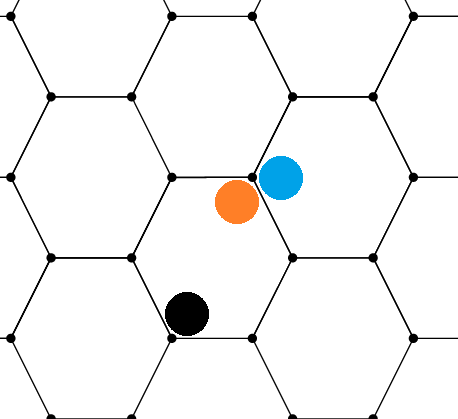

### Method #2: Neighboring hexes by prefix

We can eliminate *some* of the problems with our previous approach by looking at the length of the shared prefix of the WHERE Placekeys. See the chart below from [the Placekey whitepaper](https://docs.placekey.io/Placekey_Technical_White_Paper.pdf). Suppose we are interested in counting the parking meters within 443.2 meters of each POI in San Francisco. We can use the WHERE portion of Plackey to estimate these counts.

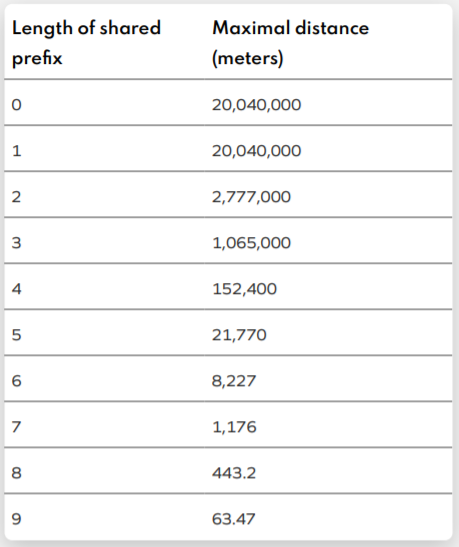

In the last section we merged on the entire 9 characters of the WHERE part of each Placekey. In this section, we match on the first 8 characters to include some of the adjacent hexes.

In [ ]:
meters_placekey2 = meters_placekey.copy()
meters_placekey2['where_placekey_8'] = meters_placekey2['placekey'].str[0:11]

meters_gb2 = meters_placekey2.groupby('where_placekey_8').agg(
    {
        'OBJECTID' : 'count'
        }).reset_index().rename({'OBJECTID' : 'meters'}, axis=1)

print(meters_gb2.shape)
meters_gb2.head(3)

In [ ]:
sf_places_where2 = sf_places.copy()
sf_places_where2['where_placekey_8'] = sf_places_where2['placekey'].str[7:18]

cols = list(sf_places_where2.columns)
cols.pop(cols.index('where_placekey_8'))
sf_places_where2 = sf_places_where2[['where_placekey_8'] + cols]

sf_places_where2.head(3)

In [ ]:
df = meters_gb2.merge(sf_places_where2, on='where_placekey_8', how='right')
print(df.shape)
df.head()

##### Considerations

Although this approach is better than the "Only Same-Hex" approach, we **still** run the risk of missing nearby parking meters that happen to have different parent hexes. The image below shows an example of this. We can do better still.

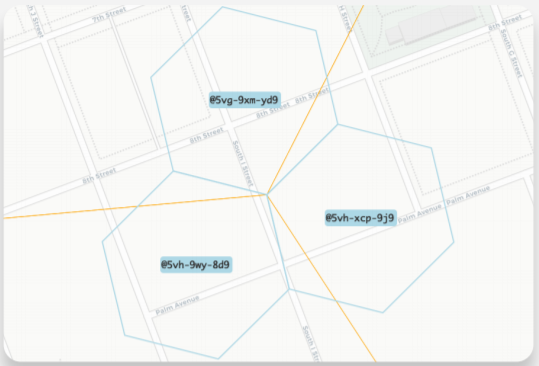

### Method #3: All neighboring hexes

A more thorough solution to estimate the number of nearby parking meters is to include the counts for **all** adjacent hexes. Python's `placekey` package has some useful functions to make this easier.

First, we add a column called `geometry` for the shape of each Placekey hexagon.

In [ ]:
meters_gb3 = meters_gb.copy().drop('meters',axis=1)
meters_gb3['geometry'] = meters_gb3.apply(lambda row : pk.placekey_to_wkt(row['placekey']), axis=1)
meters_gb3.head()

Second, we use the `geometry` column to find all adjacent Placekey hexagons.

In [ ]:
def getBorderingPlacekeys(placekey):
  covering_placekeys = pk.wkt_to_placekeys(placekey, include_touching=True)
  return(list(covering_placekeys['boundary'] + covering_placekeys['interior']))

meters_gb3['adjacent'] = meters_gb3.apply(lambda row : getBorderingPlacekeys(row['geometry']), axis=1)
meters_gb3.head(3)

Third, we explode by the list of adjacent Placekeys and merge the count of parking meters---from `meters_gb`---on the `adjacent` column.

In [ ]:
meters_gb3_x = meters_gb3.explode('adjacent')
meters_gb3_x = meters_gb3_x.merge(meters_gb, left_on='adjacent', right_on='placekey', suffixes=('','_y')).drop('placekey_y',axis=1)
meters_gb3_x.head()

Fourth, we group by the original Placekey, taking the sum of parking meter counts for all adjacent Placekey hexagons. This includes the count of parking meters in the original Placekey hexagon.

In [ ]:
meters_gb3_final = meters_gb3_x.groupby('placekey').agg({'meters' : 'sum'}).reset_index()
print(meters_gb3_final.shape)
meters_gb3_final.head()

In [ ]:
df = sf_places_where.merge(meters_gb3_final, left_on='where_placekey', right_on='placekey', how='left', suffixes=['_poi',''])
df['meters'] = df['meters'].fillna(0).astype(int)
print(df.shape)
cols_of_interest = ['placekey_poi','where_placekey','meters','location_name','top_category','sub_category','phone_number','open_hours']
df[cols_of_interest].head()

##### Considerations

The WHERE Placekeys represent hexagonal spaces (not perfect circles), so these counts are just estimates.

All POIs in the same hexagon are given the same estimates, even if they are on opposite sides of the hexagon. See the image below. If POIs are at the black, red, and blue dots, their parking meter counts include the counts of parking meters in each of the hexagons that are shaded gray.

Keep in mind, each hexagon has a diameter of about 132 meters, which means we can join non-POI data to POI data at high resolution.

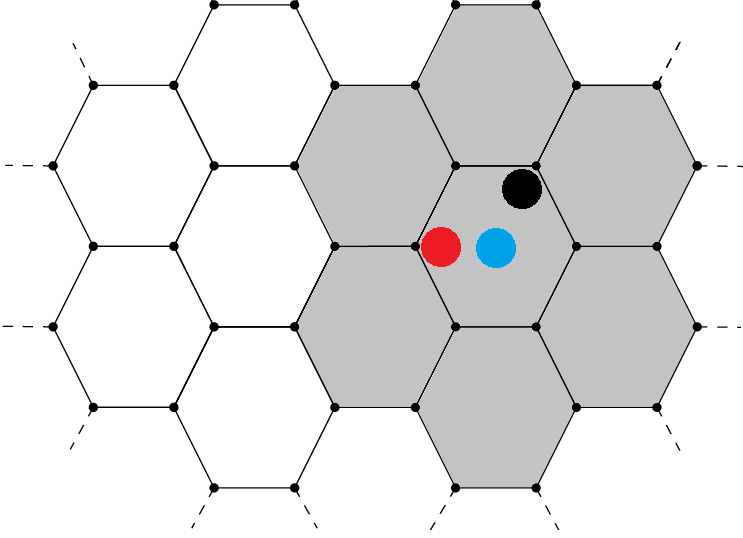

# Conclusion

In this tutorial, we demonstrated how to join POI and non-POI datasets with Placekey. This is made easy with the WHERE portion of Placekey, which corresponds to a unique H3 hexagon on Earth's surface, with a diameter of about 132 meters.

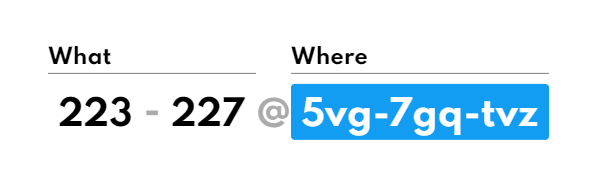

Along with joining the datasets, we also covered some considerations to keep in mind. For our use case of estimating the number of nearby parking meters in San Francisco, we sacrificed some accuracy to avoid computing 759 million distances for the 23,000+ POIs and 33,000+ parking meters in the city.

When joining POI and non-POI datasets, the exact process may vary to fit your needs and assumptions. This tutorial gives you the background needed to simplify that process with Placekey.
<br><br><br>

***Want to learn more?***
*   *Check out [the Placekey website](https://www.placekey.io/).*